# 02.PyTorch神经网络分类
分类问题涉及预测某物是一个东西还是另一个东西。

例如：

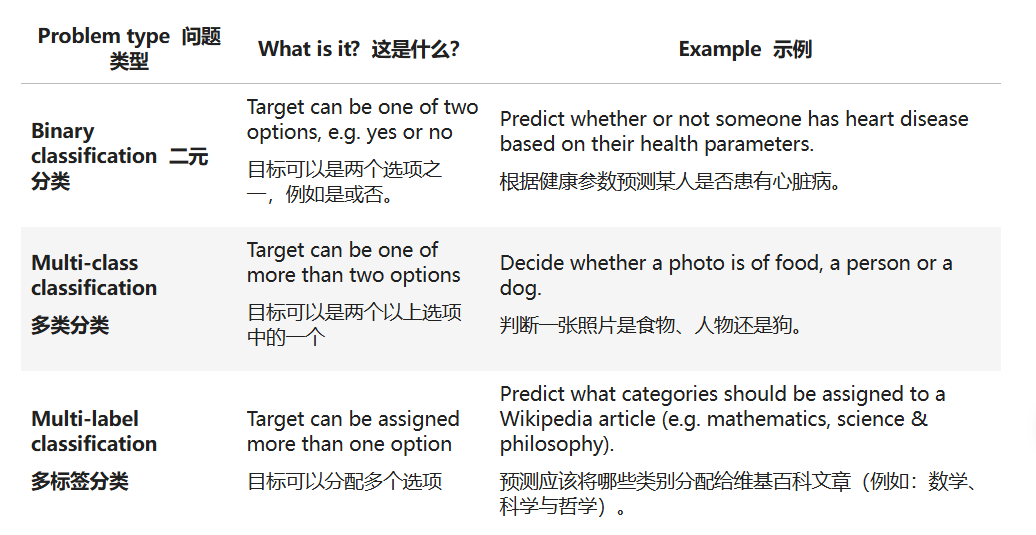

分类与回归是最常见的机器学习的问题之一。

在这个笔记本中，我们将使用PyTorch解决几个不同的分类问题。

换句话说，获取一组输入并预测这些输入属于哪个类别。

## 将要涵盖的内容
将重申01.PyTorch Workflow中涵盖的PyTorch工作流程。

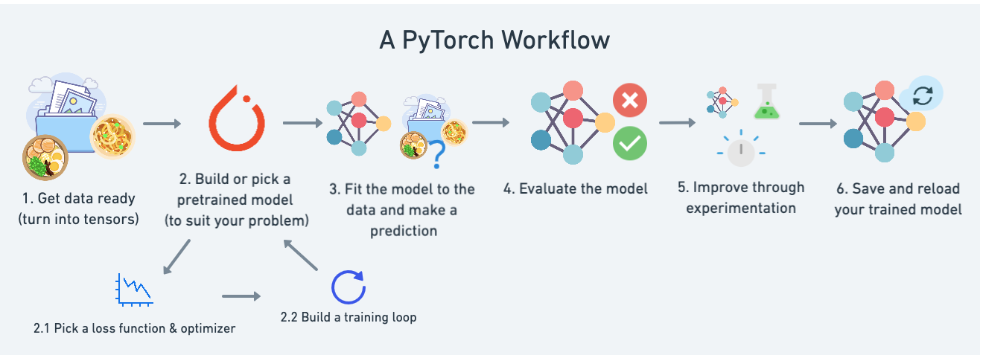

除了尝试预测一条直线（预测一个数字，也称为回归问题），我们将处理一个分类问题。

具体来说，将涵盖：

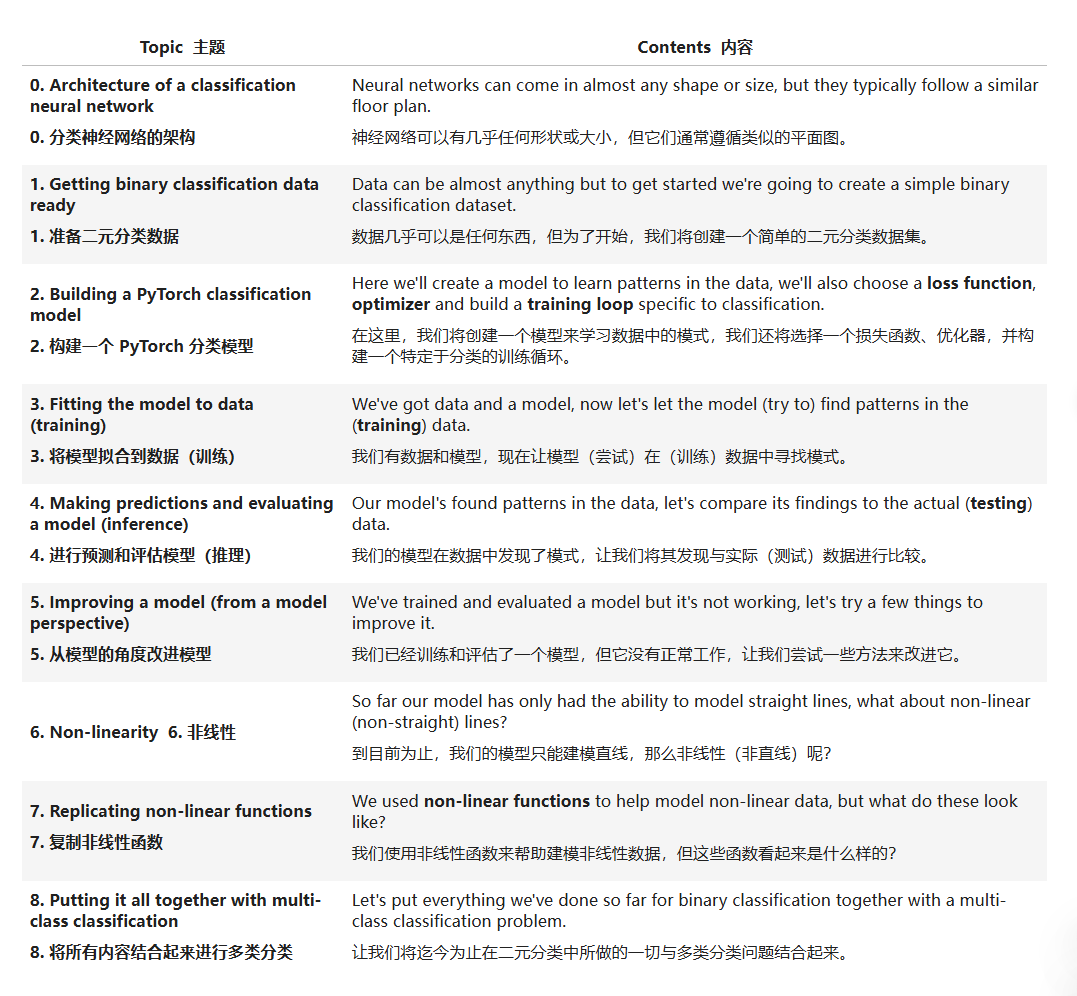

### 0.分类神经网络的架构
在开始编写代码之前，先来看一看分类神经网络的一般架构。

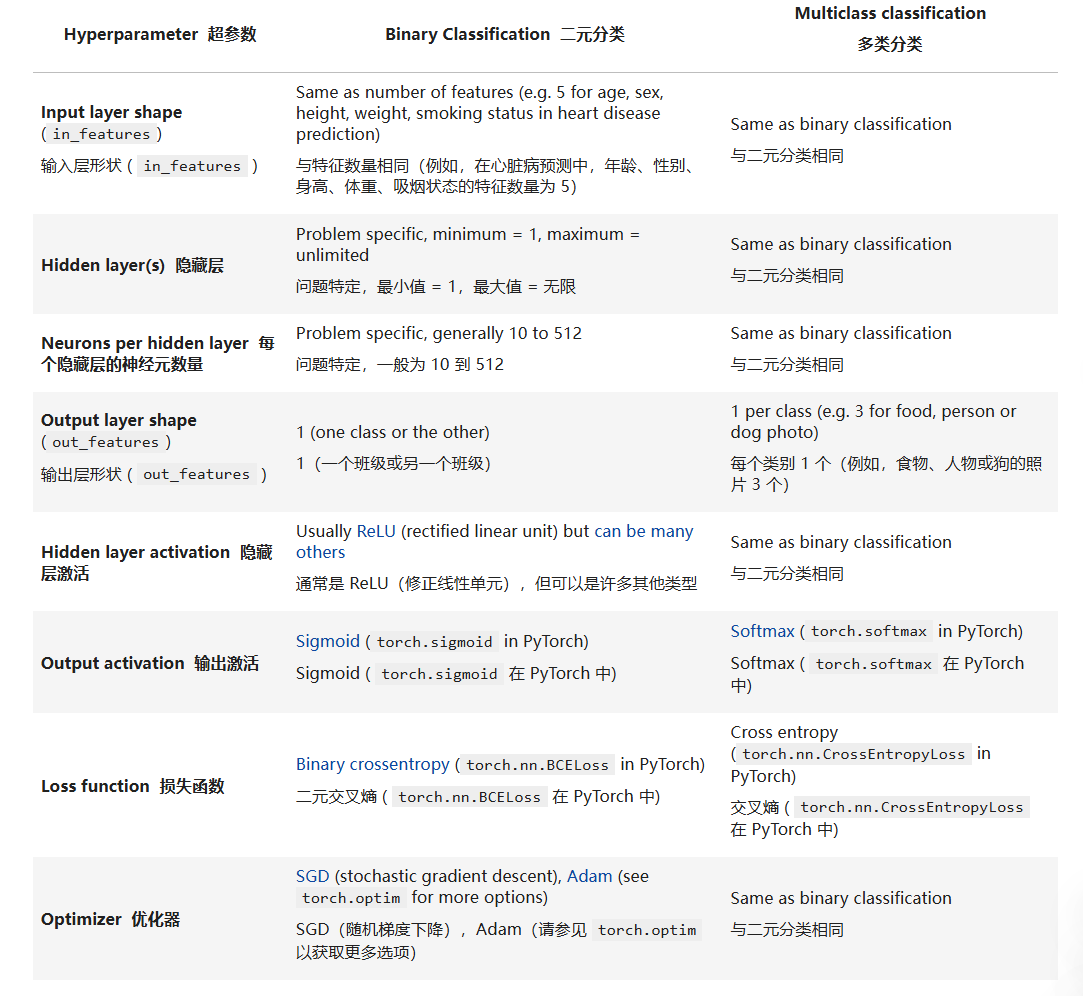

这个分类神经网络组件的成分列表会根据正在处理的问题的不同进行调整。

### 1. 制作分类数据并准备好它
现在开始制作一些数据。

使用`Scikit-Learn`中的`make_circles()`方法生成两个不同颜色的圆圈。

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # 给点噪音给这些点。
                    random_state=42
                    ) # keep random state so we get the same values

查看前5个`X`和`y`值

In [2]:
print(f"First 5 X features:\n {X[:5]}")
print(f"\n First 5 y labels:\n {y[:5]}")

First 5 X features:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

 First 5 y labels:
 [1 1 1 1 0]


看起来是一个`y`对应两个`X`值。

继续遵循数据探索者的座右铭`可视化、可视化、可视化`，将它们放入一个`pandas DataFrame`中。

In [3]:
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0], "X2": X[:, 1],
    "label": y
})
circles.head(10)

X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0

看起来每对`X`特征`X1, X2`都有一个标签`y`值为0或1。

这是一个二元分类，因为只有两个选项，`0`或`1`。
 

In [4]:
# 查看标签，查看每个类别有多少值
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

每个标签各有500个，非常均匀。

现在来绘制他们

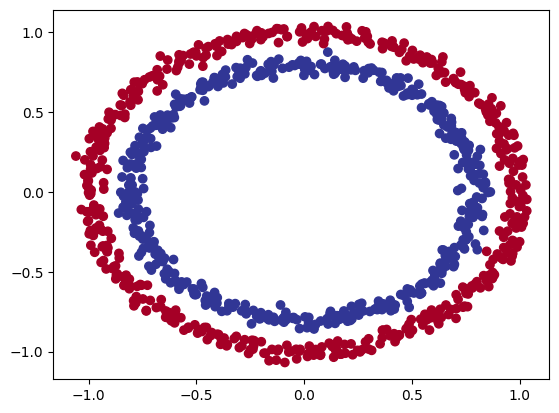

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

#### 1.1 输入和输出的形状
深度学习中最常见的错误之一就是形状错误。

不匹配张量和张量操作的形状将导致模型中的错误。

在整个课程中，将看到很多这样的内容。

要做的是不断熟悉正在处理的数据的形状。

我的输入是什么形状？我的输出是什么形状？


In [6]:
# Check the shape of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

查看单个样本的值和形状（特征和标签）通常是有帮助的。

这样做可以帮助理解期望从模型中获得的输入和输出的形状。

In [7]:
# View the first examle of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


这告诉我们`x`的第二维意味着有两个特征（向量），而`y`只有一个特征(标量)。

两个输入对应一个输出。


### 1.2 将数据转换为张量并创建训练和测试集划分
需要：
* 将数据转换为张量
* 将数据集分为训练集和测试集（将在训练集上训练一个模型，以学习`X`和`y`之间的模式，然后在测试数据集上评估这些学习到的模式。）

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

现在数据是张量格式，分成训练集和测试集！

使用Scikit-learn中有用的函数`train_test_split()`.

将使用`test_size = 0.2`（80%训练，20%测试），并且由于数据的划分是随机发生的，让我们使用`random_state=42`以便划分是可重复的.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
    )
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

看起来有800个训练样本,200个测试样本。

## 2. 构建模型

In [10]:
# 导入标准库
import torch
from torch import nn

# 设置与设备无关的代码（在可用时，在GPU上运行）
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

我们需要一个能够处理我们的`X`数据作为输入，并生成类似于我们的`y`数据的输出的模型。

换句话说，给定`X`（特征），希望模型预测`y`(标签)。

这些具有特征和标签的设置被称为监督学习，因为数据在告诉模型在给定特定输入时输出应该是什么。

要创建这样的模型，他需要处理`X`和`y`的输入和输出的形状。

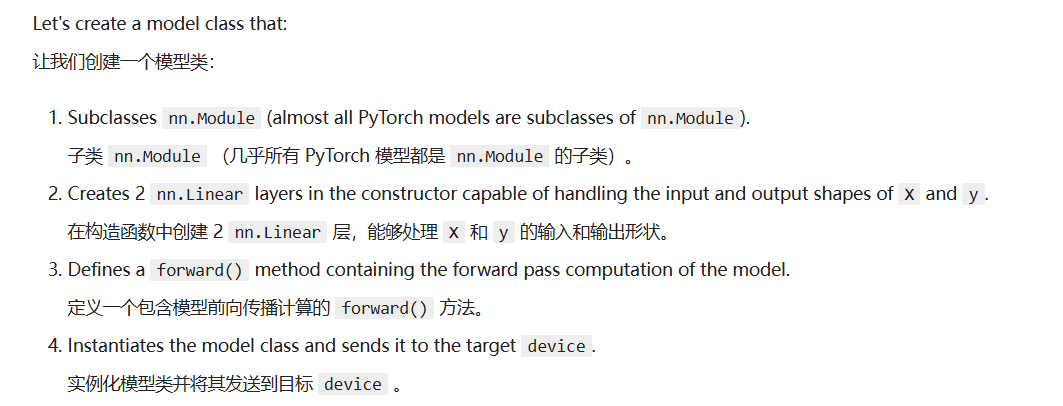

In [11]:
# 1. Construcrt a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. 创建两个 nn.Linear 层，以处理 X 和 y 的输入和输出形状。
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # 输入两个特征（X），产生五个特征。
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # 接受5个特征，产生1个特征（y）

    # 3. 定义一个包含前向传播计算的前向方法
    def forward(self, x):
        # 返回层_2的输出，单个特征，形状与y相同
        return self.layer_2(self.layer_1(x)) # 计算首先经过layer_1，然后layer_1的输出经过layer_2。
    
# 4. 创建模型的实例并将其发送到目标设备
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

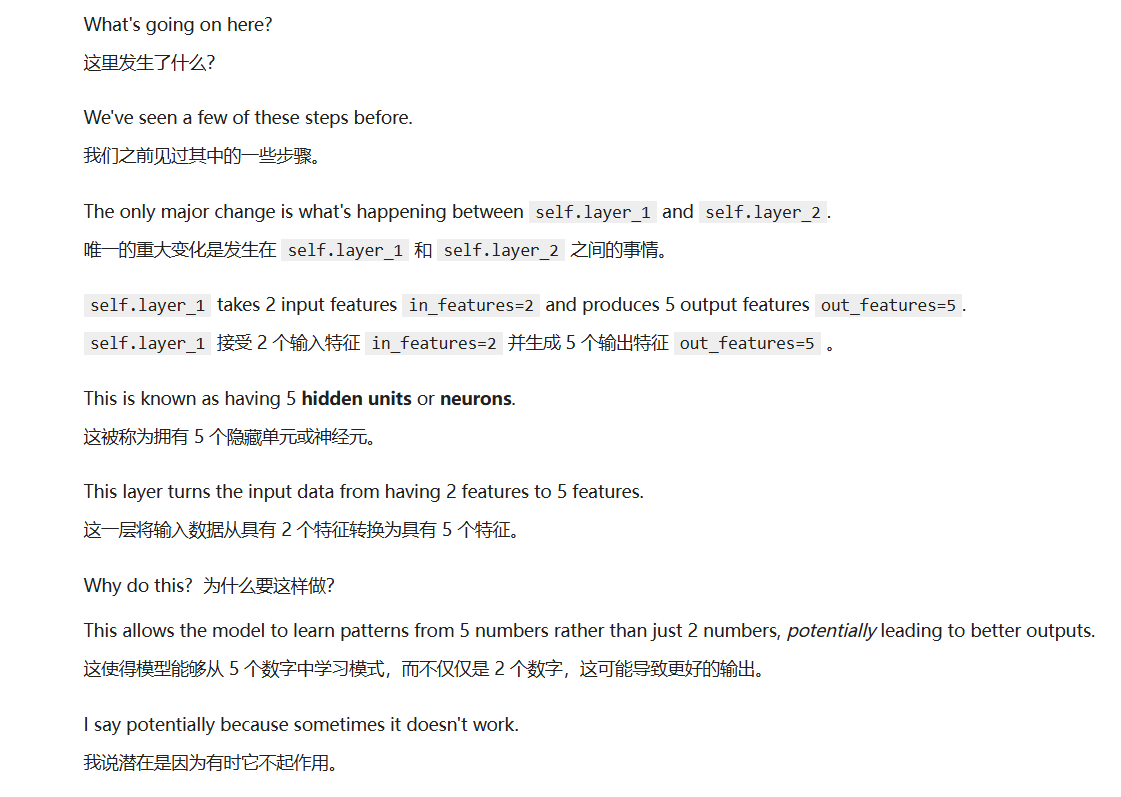

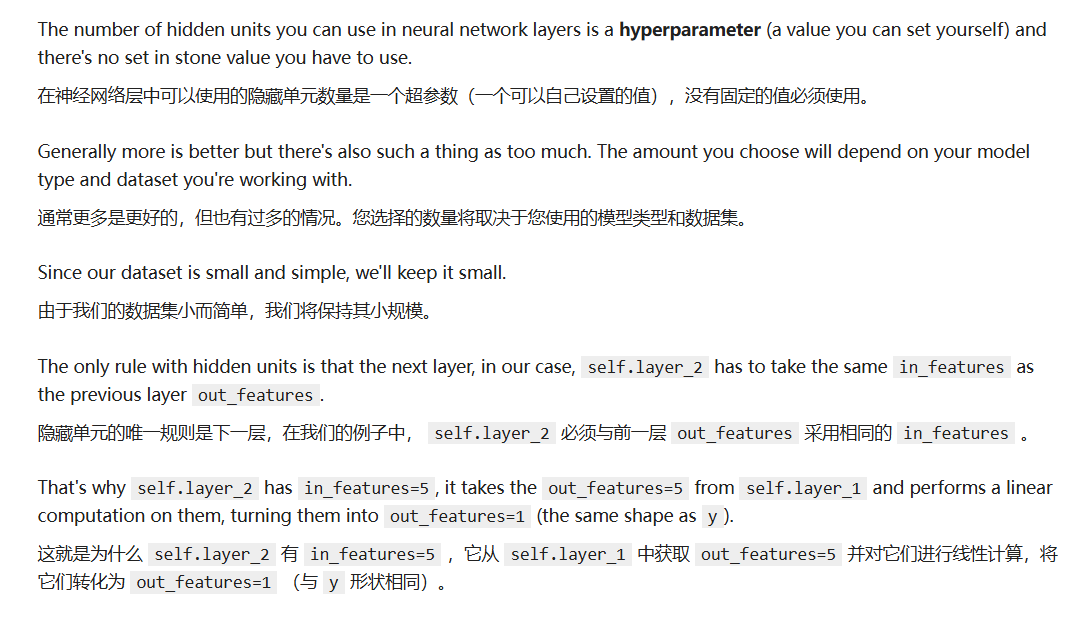

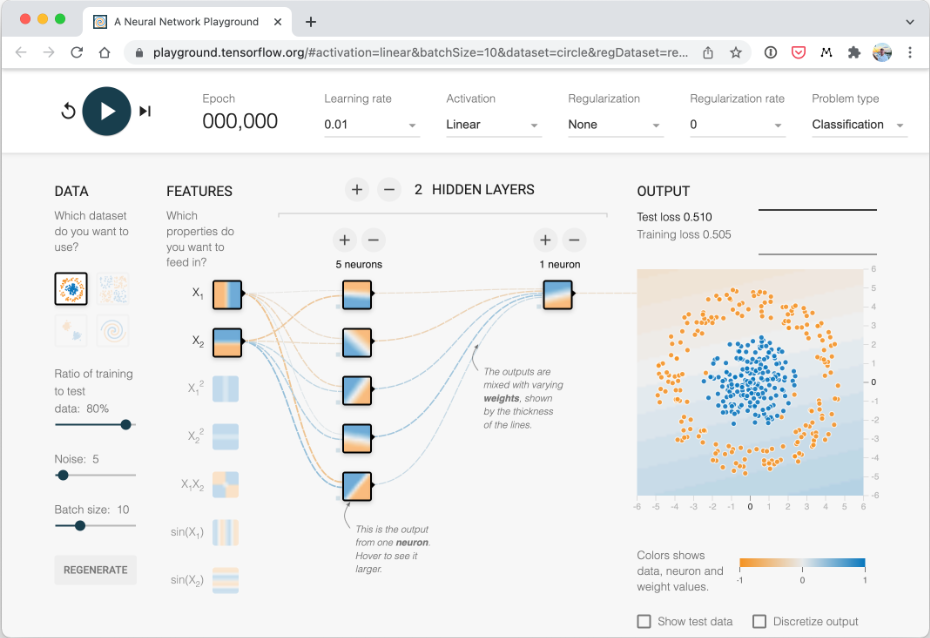

`nn.Sequential`对输入数据进行前向传播计算，按照层出现的顺序进行。

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

现在我们有了一个模型，让我们看看当我们通过它传递一些数据时会发生什么

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[1.0690],
        [1.4781],
        [0.2837],
        [1.2903],
        [0.7395],
        [0.9857],
        [1.7764],
        [1.6622],
        [0.2657],
        [1.5106]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 设置损失函数和优化器
下面是分类问题常用的损失函数和优化器

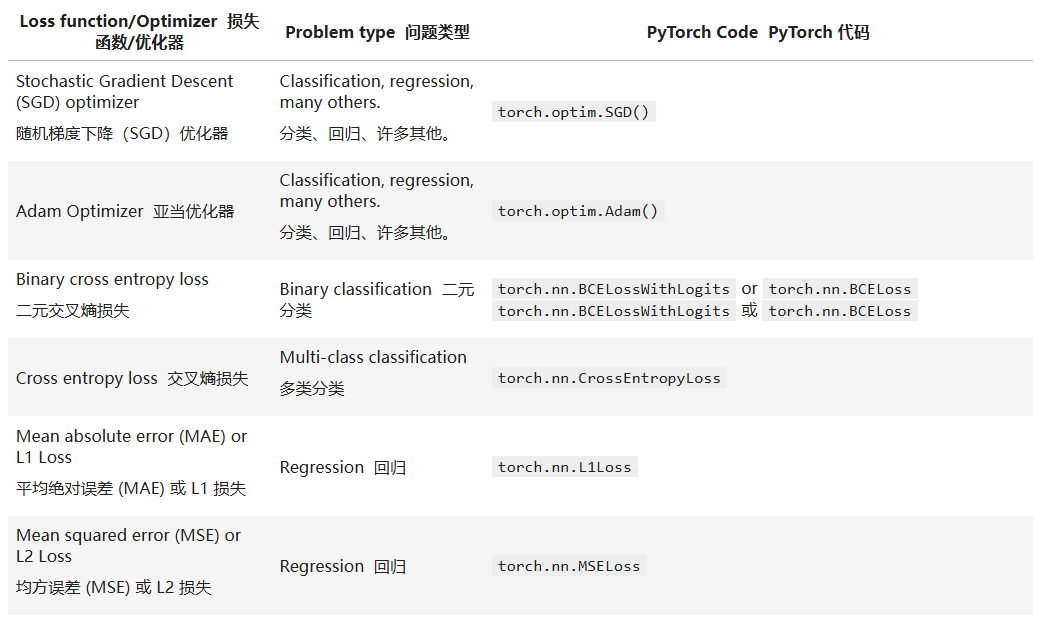

现在在处理二分类问题，让我们使用二元交叉熵损失函数。

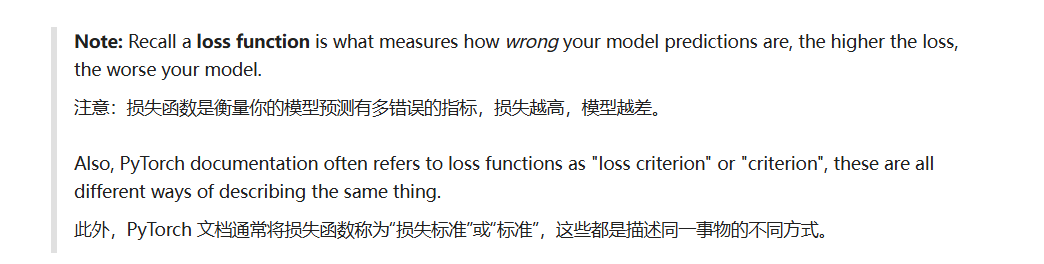

PyTorch有两个二元交叉熵实现：
1. `torch.nn.BCELoss()`-创建一个损失函数，用于测量目标（标签）和输入（特征）之间的二元交叉熵。
1. `torch.nn.BCEWithLogitLoss`-与上面相同，只是内置了一个sigmoid层(`nn.Sigmoid`)（我们很快会看到这意味着什么）


In [14]:
# 创建一个损失函数，用第二种
loss_fn = nn.BCEWithLogitsLoss()

# 创建一个优化器
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

现在创建一个评估指标，如果损失函数是衡量模型是有多错误，那么评估指标就是衡量模型有多正确。

In [15]:
# 计算准确率（分类指标）
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() 计算两个张量相等的位置
    acc = (correct / len(y_pred)) * 100
    return acc

现在可以在训练模型的时候使用这个功能，以便在损失的同时衡量它的性能。

### 3. 训练模型
下面是PyTorch训练循环的步骤：

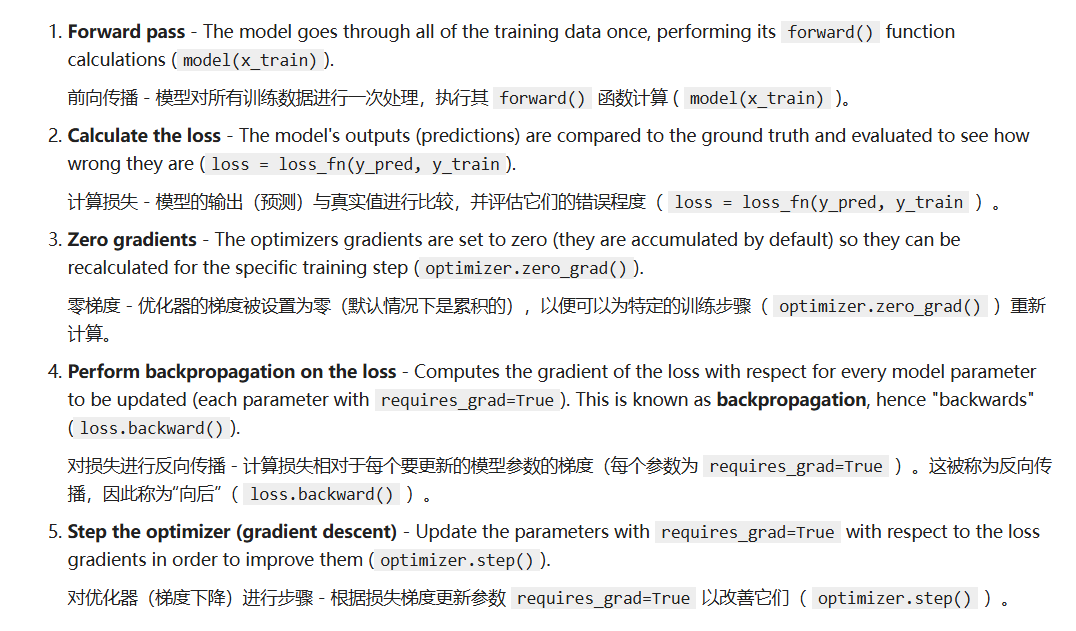

# 3.1 从原始模型输出到预测标签（logits->预测概率->预测标签）
在训练循环步骤之前，让我们看看在前向传播过程中我们的模型输出了什么（前向传播由 `forward()` 方法定义）。

为此，传递给模型一点数据

In [16]:
# # 查看测试数据前5个前向传播的输出
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[1.0690],
        [1.4781],
        [0.2837],
        [1.2903],
        [0.7395]], device='cuda:0', grad_fn=<SliceBackward0>)

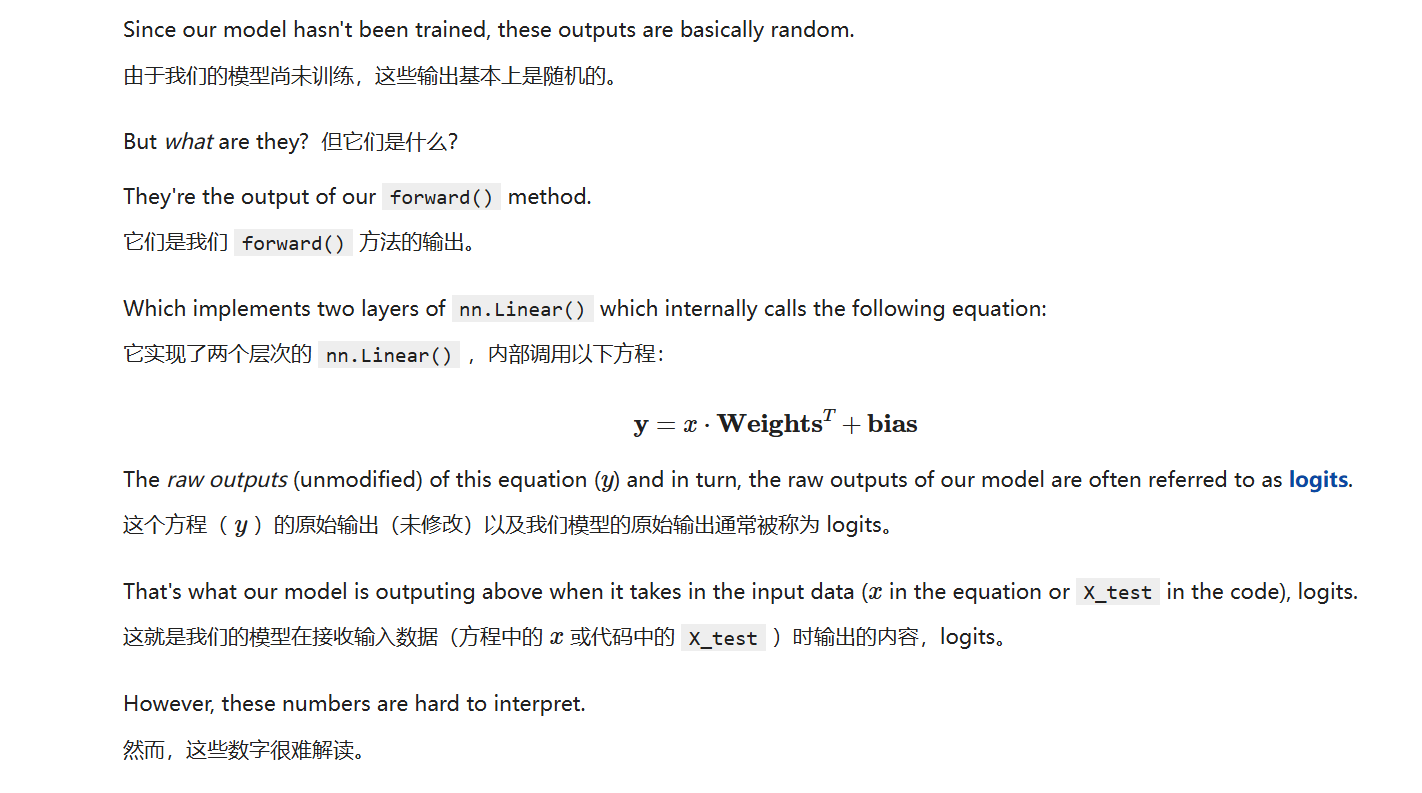

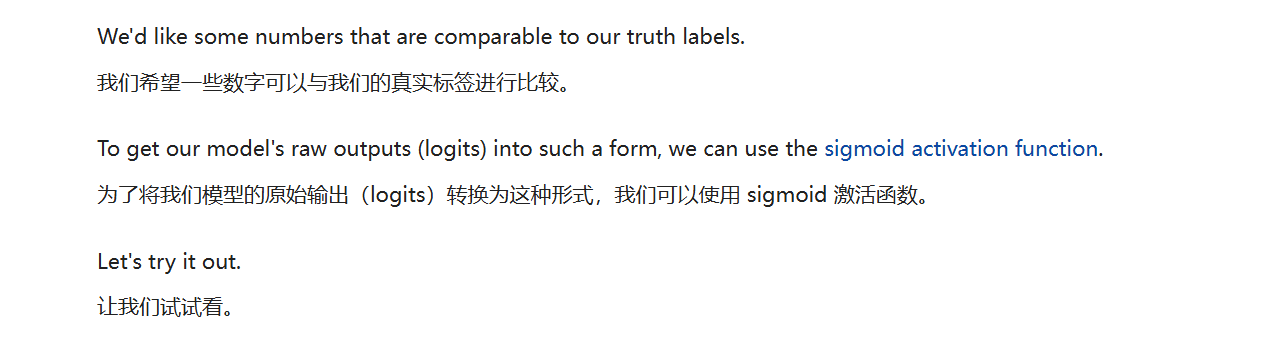

In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.7444],
        [0.8143],
        [0.5705],
        [0.7842],
        [0.6769]], device='cuda:0', grad_fn=<SigmoidBackward0>)

它们现在以预测概率的形式存在（我通常称这些为 `y_pred_probs` ），换句话说，这些值现在表示模型认为数据点属于某个类别的程度。

在我们的案例中，由于处理的是二元分类，所有理想的输出是0或1.

所以这些值可以被视为决策边界。

越接近`0`，模型越认为样本属于类`0`；越接近`1`，模型越认为样本呢属于类`1`。

更具体地说:

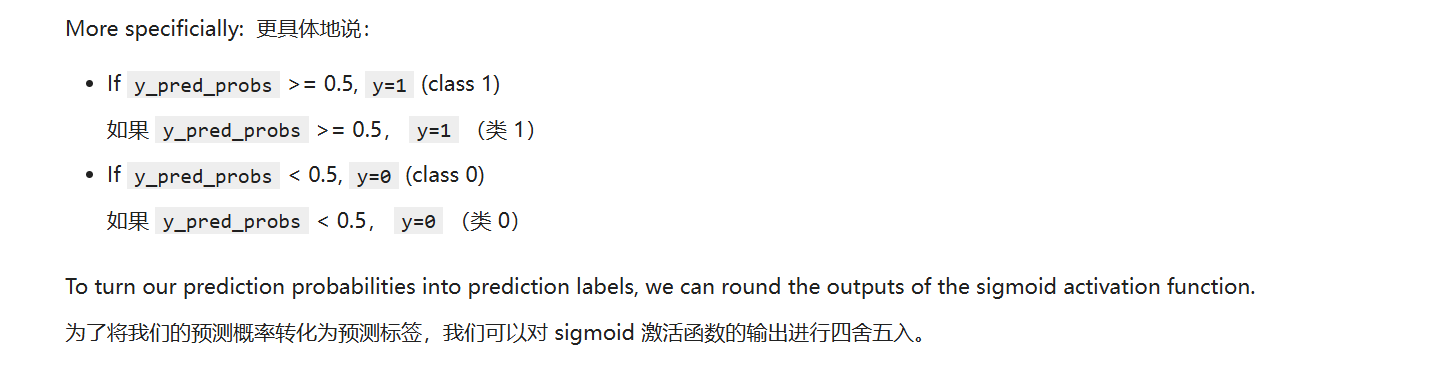

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs) # 通过 torch.round 函数，概率大于等于0.5的会被转换为1（表示该类为正），小于0.5的会被转换为0（表示该类为负）。

# In dull
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

太好了！现在我们的模型预测的结果看起来与我们的真实标签（ y_test ）格式相同。

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

这意味着我们将能够将模型的预测与测试标签进行比较，以查看器其形状如何！

回顾一下，我们使用`sigmoid`函数将输出结果（logits）转化为预测概率。


然后通过四舍五入将预测概率转换为预测标签。

有几个注意点：
1. sigmoid激活函数的使用通常仅用于二分类logits。对于多分类，将考虑使用softmax激活函数。
1. 当将我们模型的原始输出传递给 `nn.BCEWithLogitsLoss` 时，不需要使用 sigmoid 激活函数（logits 损失中的“logits”是因为它作用于模型的原始 logits 输出），这是因为它内置了 sigmoid 函数。

### 3.2 构建训练和测试循环
开始训练100个周期，并且每隔10个周期就输出一次结果。

In [20]:
torch.manual_seed(42)

epochs = 100 

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# 创建训练和测试循环
for epoch in range(epochs):
    ### 训练ing
    model_0.train()

    # 1. 前向传播过程
    y_logits = model_0(X_train).squeeze() # 挤压以去除多余的 `1` 维度，除非模型和数据在同一设备上，否则这将不起作用。
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. 计算损失函数和评估指标
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. 优化器零梯度
    optimizer.zero_grad()

    # 4. 损失反向传播
    loss.backward()

    # 5. 优化器更新
    optimizer.step()

    ### 测试ing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.81733, Accuracy: 50.12% | Test loss: 0.84027, Test acc: 50.00%
Epoch: 10 | Loss: 0.74135, Accuracy: 55.00% | Test loss: 0.75759, Test acc: 55.50%
Epoch: 20 | Loss: 0.71245, Accuracy: 59.38% | Test loss: 0.72393, Test acc: 56.00%
Epoch: 30 | Loss: 0.70101, Accuracy: 55.38% | Test loss: 0.70935, Test acc: 51.00%
Epoch: 40 | Loss: 0.69638, Accuracy: 53.50% | Test loss: 0.70266, Test acc: 48.00%
Epoch: 50 | Loss: 0.69447, Accuracy: 54.00% | Test loss: 0.69939, Test acc: 48.00%
Epoch: 60 | Loss: 0.69368, Accuracy: 52.12% | Test loss: 0.69768, Test acc: 47.50%
Epoch: 70 | Loss: 0.69334, Accuracy: 52.00% | Test loss: 0.69671, Test acc: 46.50%
Epoch: 80 | Loss: 0.69318, Accuracy: 51.00% | Test loss: 0.69612, Test acc: 47.00%
Epoch: 90 | Loss: 0.69311, Accuracy: 51.12% | Test loss: 0.69574, Test acc: 47.50%


虽然完成了训练，但是结果好像没变。

每个数据分割的准确率几乎都在 50%上下波动。

因为我们正在处理一个平衡的二元分类问题，这意味着我们的模型表现得和随机猜测一样好（在有 500 个类别 0 和类别 1 的样本中，一个每次都预测类别 1 的模型将达到 50%的准确率）。

## 4. 进行预测并评估模型
从指标看，模型似乎是在随机猜测。

我们该如何进一步调查这个问题？

可视化，可视化，可视化！

让我们绘制一个图，展示我们模型的预测、它试图预测的数据以及它为判断某个东西是类别 0 还是类别 1 而创建的`决策边界`。

In [21]:
import requests  # 导入requests模块，用于发送HTTP请求
from pathlib import Path  # 从pathlib模块导入Path类，用于处理文件路径

# 从 Learn PyTorch 仓库下载辅助函数（如果尚未下载）
# 检查当前目录下是否存在名为helper_functions.py的文件
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")  # 如果文件已存在，打印提示信息并跳过下载
else:
    print("Downloading helper_functions.py")  # 如果文件不存在，打印提示信息，准备下载
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")  # 发送HTTP GET请求以获取文件内容
    with open("helper_functions.py", "wb") as f:  # 以二进制写入模式打开文件，准备写入内容
        f.write(request.content)  # 将获取到的文件内容写入本地文件

from helper_functions import plot_predictions, plot_decision_boundary  # 从helper_functions.py文件中导入plot_predictions和plot_decision_boundary两个函数


helper_functions.py already exists, skipping download


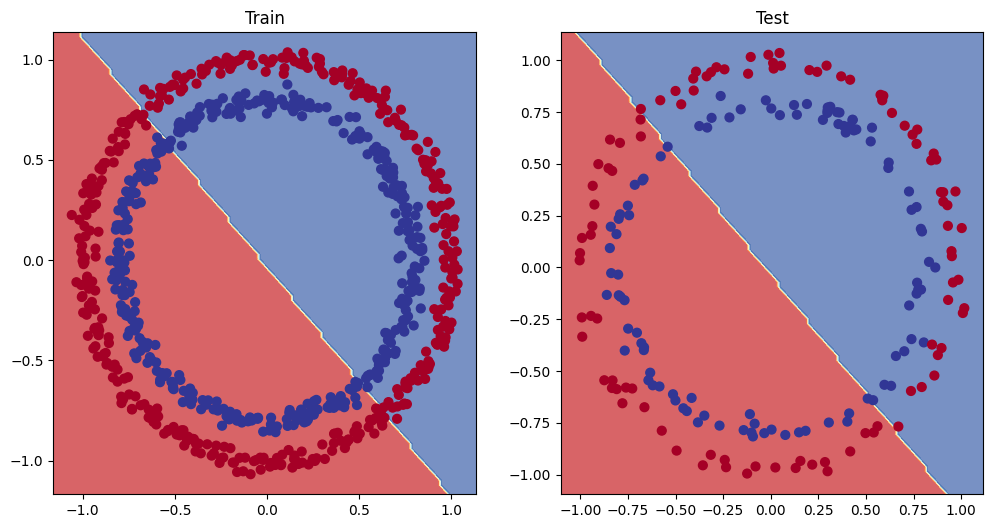

In [22]:
# 绘制训练集和测试集的决策边界
plt.figure(figsize=(12, 6))  # 创建一个新的图形，设置图形的大小为12英寸宽，6英寸高
plt.subplot(1, 2, 1)        # 在当前图形中创建子图，1行2列，选择第一个子图（左上角）
plt.title("Train")          # 为第一个子图添加标题“Train”
plot_decision_boundary(model_0, X_train, y_train)  # 绘制训练集的决策边界，传入模型、训练特征集和训练标签集
plt.subplot(1, 2, 2)        # 在当前图形中创建子图，1行2列，选择第二个子图（右上角）
plt.title("Test")           # 为第二个子图添加标题“Test”
plot_decision_boundary(model_0, X_test, y_test)     # 绘制测试集的决策边界，传入模型、测试特征集和测试标签集


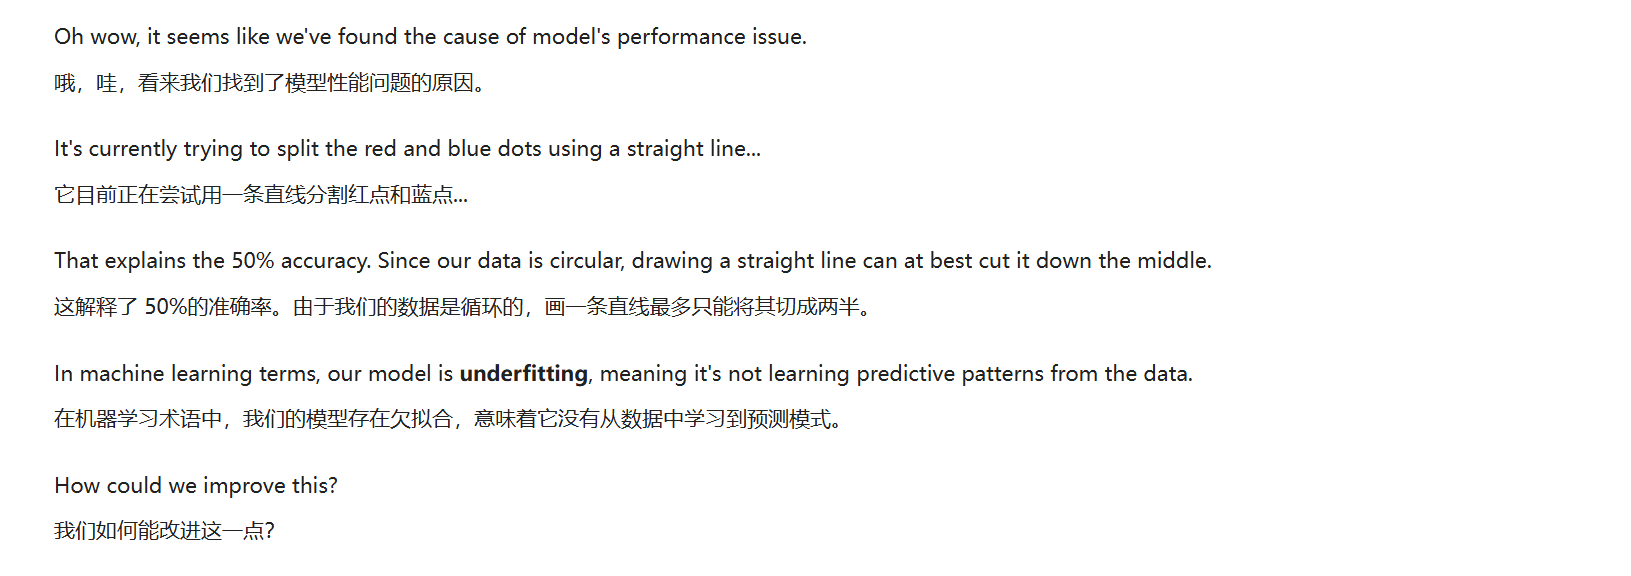

## 5. 从模型的角度改进模型
专注于模型（而不是数据），我们可以通过几种方式来实现这一点。

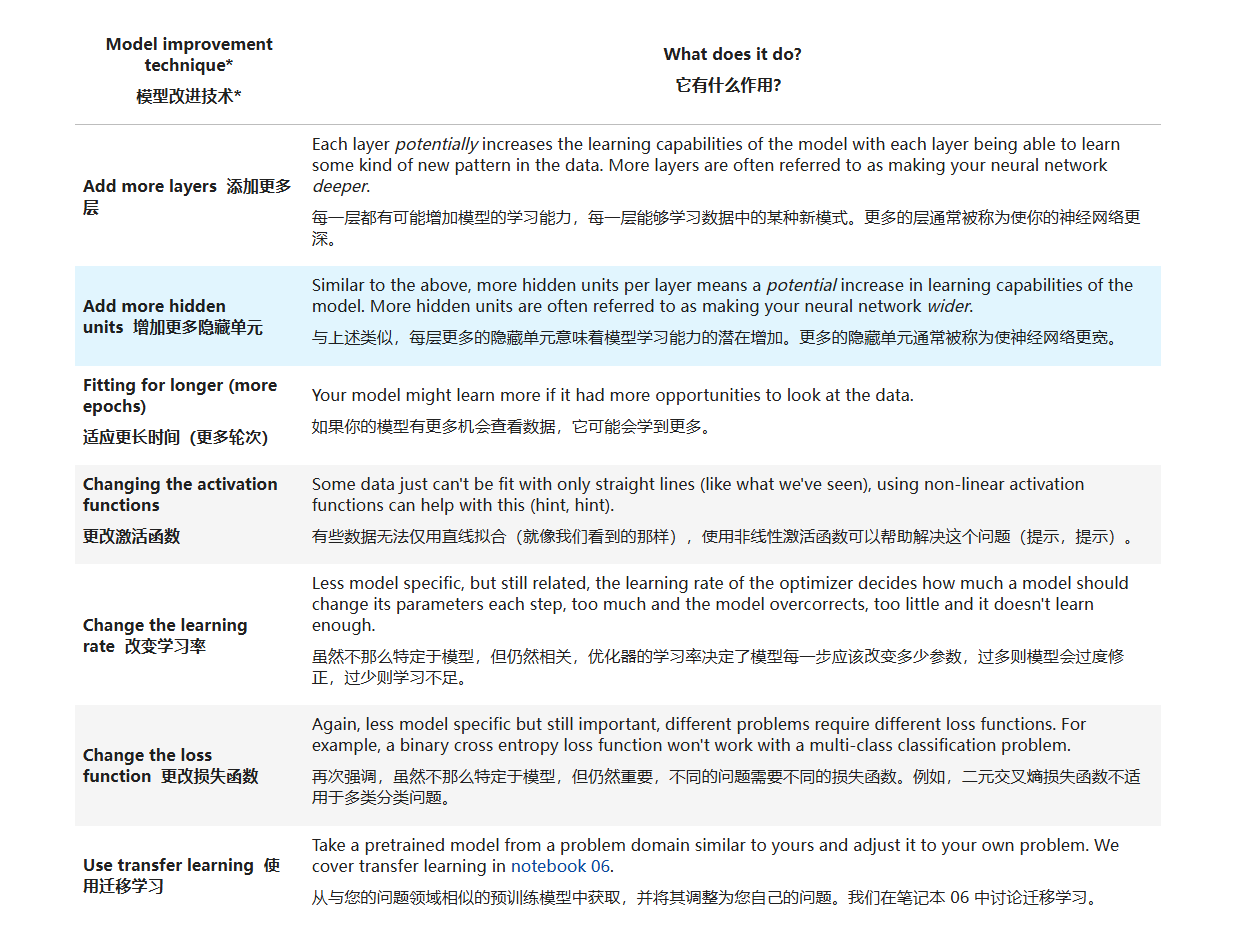

* 因为这些参数都是手动调整的，所以它们被称为超参数。


来试试看，在模型中添加一层，训练更长的时间(epoch=1000)，并将隐藏单元从5增加到10、会发生什么？

In [23]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

有了一个新的模型，重新创建一个损失函数和优化器实例，使用和之前相同的设置。

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

In [25]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


什么？我们的模型训练时间更长，并增加了一层，但它看起来仍然没有比随机猜测学到任何更好的模式|????

可视化看一看

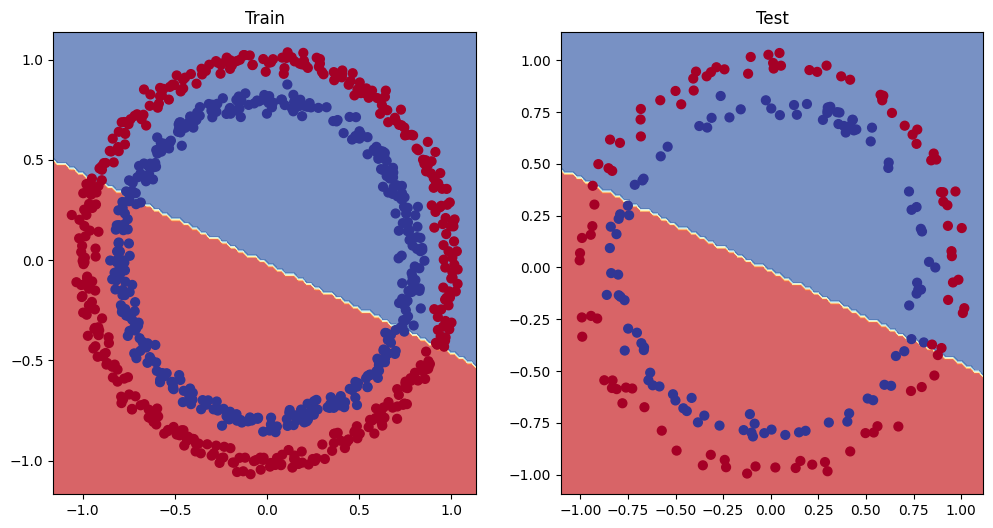

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

模型仍然是红点和蓝点之间的直线

### 5.1 准备数据以查看我们的模型是否可以拟合成一条直线

In [27]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [28]:
# 分数据集
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


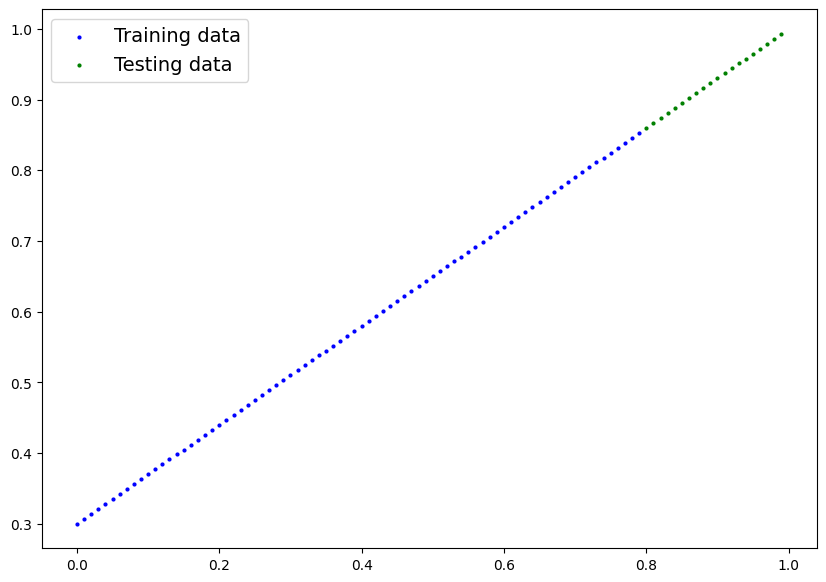

In [29]:
# 可视化
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

### 5.2 调整`model_1`以适应直线
现在我们有了一些数据，让我们重新创建 `model_1` ，但使用适合我们回归数据的损失函数。

In [30]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

我们将设置损失函数为 `nn.L1Loss()` （与平均绝对误差相同），优化器为 `torch.optim.SGD()` 。

In [31]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [32]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


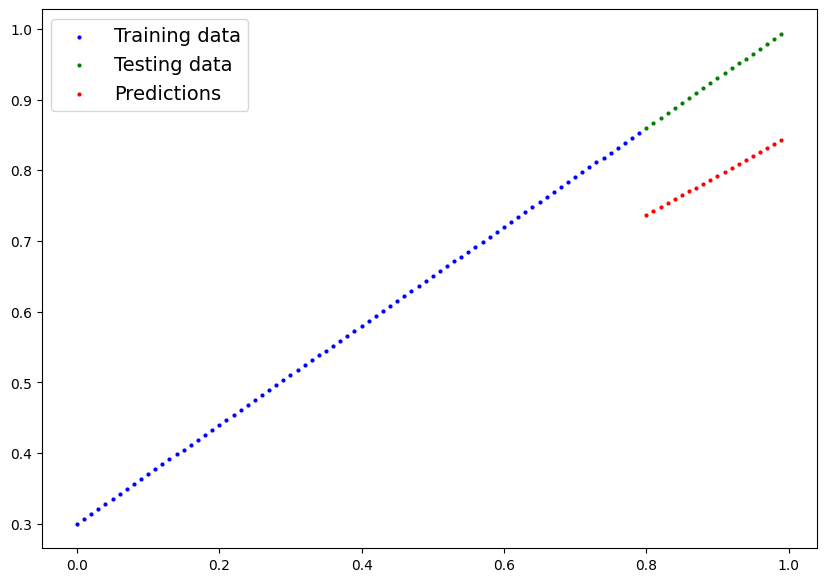

In [33]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. 缺失的部分：非线性
我们已经看到我们的模型可以绘制直线（线性），这要归功于它的线性层。

但是我们能否赋予它绘制非直线（非线性）线条的能力？

#### 6.1 重新创建非线性数据（红色和蓝色的圆圈）
首先，创建数据，以便重新开始，我们将使用与之前相同的设置。

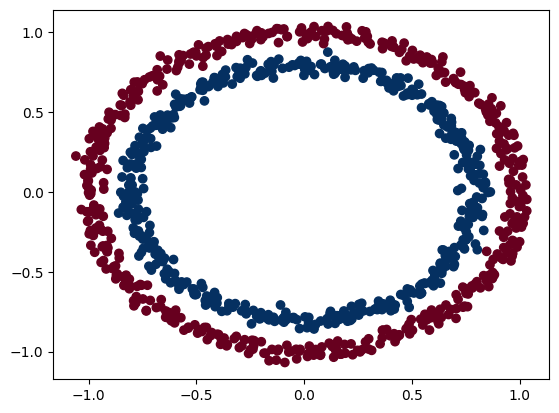

In [48]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(
    n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [49]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 构建非线性模型
当为模型引入使用非线性激活函数的能力会发生什么？

PyTorch有一堆现成的非线性激活函数，它们做的事情相似但又不同。

最常见且表现最好的之一是ReLU(线性修正单元，`torch.nn.ReLU()`)。

如下：

In [55]:
# 使用非线性激活函数创建模型
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=15)
        self.layer_2 = nn.Linear(in_features=15, out_features=15)
        self.layer_3 = nn.Linear(in_features=15, out_features=15)
        self.layer_4 = nn.Linear(in_features=15, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=15, bias=True)
  (layer_2): Linear(in_features=15, out_features=15, bias=True)
  (layer_3): Linear(in_features=15, out_features=15, bias=True)
  (layer_4): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
)


创建一个二元分类损失函数以及一个优化器

In [56]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.08)

### 6.3 使用非线性训练模型


In [57]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69672, Accuracy: 50.00% | Test Loss: 0.69616, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69179, Accuracy: 52.00% | Test Loss: 0.69145, Test Accuracy: 56.00%
Epoch: 200 | Loss: 0.69088, Accuracy: 61.50% | Test Loss: 0.69069, Test Accuracy: 63.50%
Epoch: 300 | Loss: 0.68949, Accuracy: 57.50% | Test Loss: 0.68956, Test Accuracy: 57.50%
Epoch: 400 | Loss: 0.68757, Accuracy: 59.88% | Test Loss: 0.68801, Test Accuracy: 58.00%
Epoch: 500 | Loss: 0.68475, Accuracy: 67.38% | Test Loss: 0.68579, Test Accuracy: 63.50%
Epoch: 600 | Loss: 0.67993, Accuracy: 67.38% | Test Loss: 0.68204, Test Accuracy: 63.00%
Epoch: 700 | Loss: 0.67090, Accuracy: 67.88% | Test Loss: 0.67519, Test Accuracy: 59.50%
Epoch: 800 | Loss: 0.65252, Accuracy: 78.12% | Test Loss: 0.66010, Test Accuracy: 71.50%
Epoch: 900 | Loss: 0.60405, Accuracy: 89.50% | Test Loss: 0.61944, Test Accuracy: 86.00%


现在看起来好看多了

### 6.4 评估使用的非线性激活函数训练的模型


In [58]:
# make predictions
model_3.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

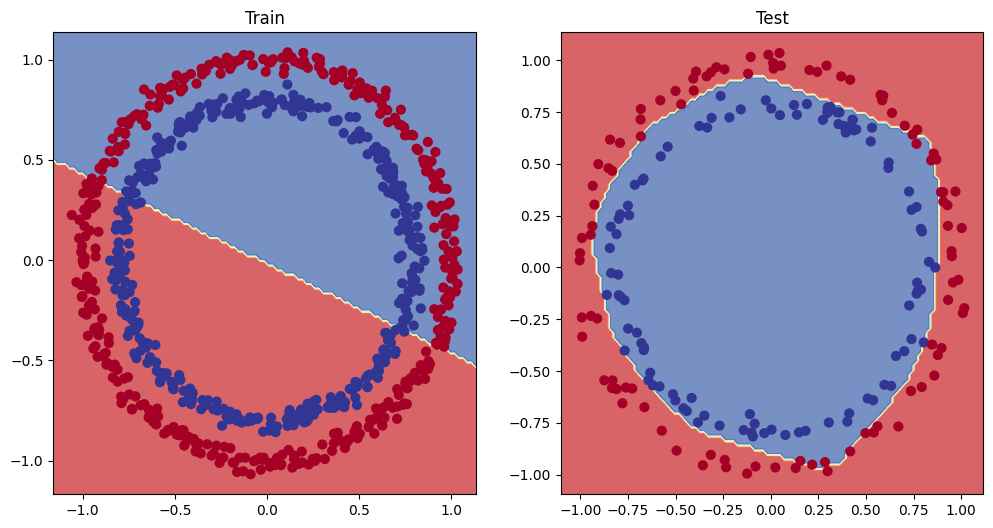

In [59]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 线性
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 非线性

## 7. 复制非线性激活函数
来看一下非线性激活函数是什么样子

In [60]:
# 创建一小部分数据
A = torch.arange(-10, 10, 1, dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

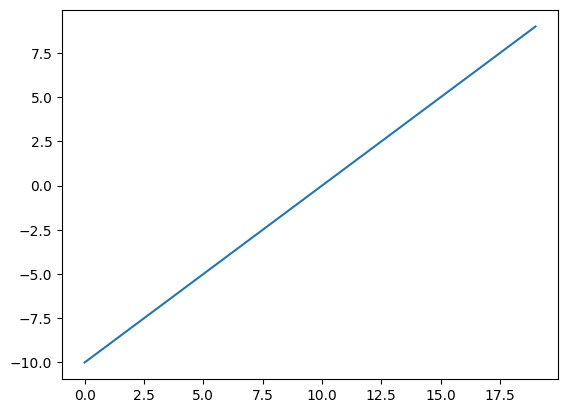

In [61]:
plt.plot(A)

首先来看看ReLU函数是如何影响它的。

ReLU函数将所有的负值变为0，正值保持不变。


In [63]:
# Create ReLU function by hand 
def relu(x):
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

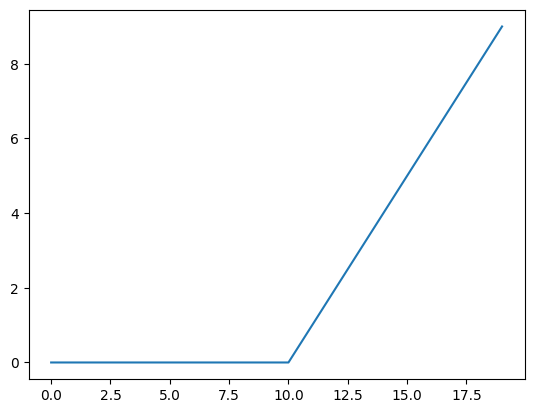

In [64]:
plt.plot(relu(A))

再看sigmoid函数。sigmoid函数如下：
$$
    S(x) = \frac{1}{1 + e^{-x}}
$$

In [65]:
# 构建函数
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

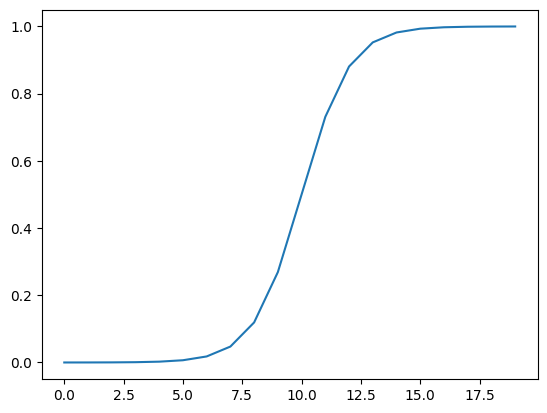

In [66]:
# 可视化
plt.plot(sigmoid(A))

## 8. 将之前的所有步骤结合起来
解决多类分类问题


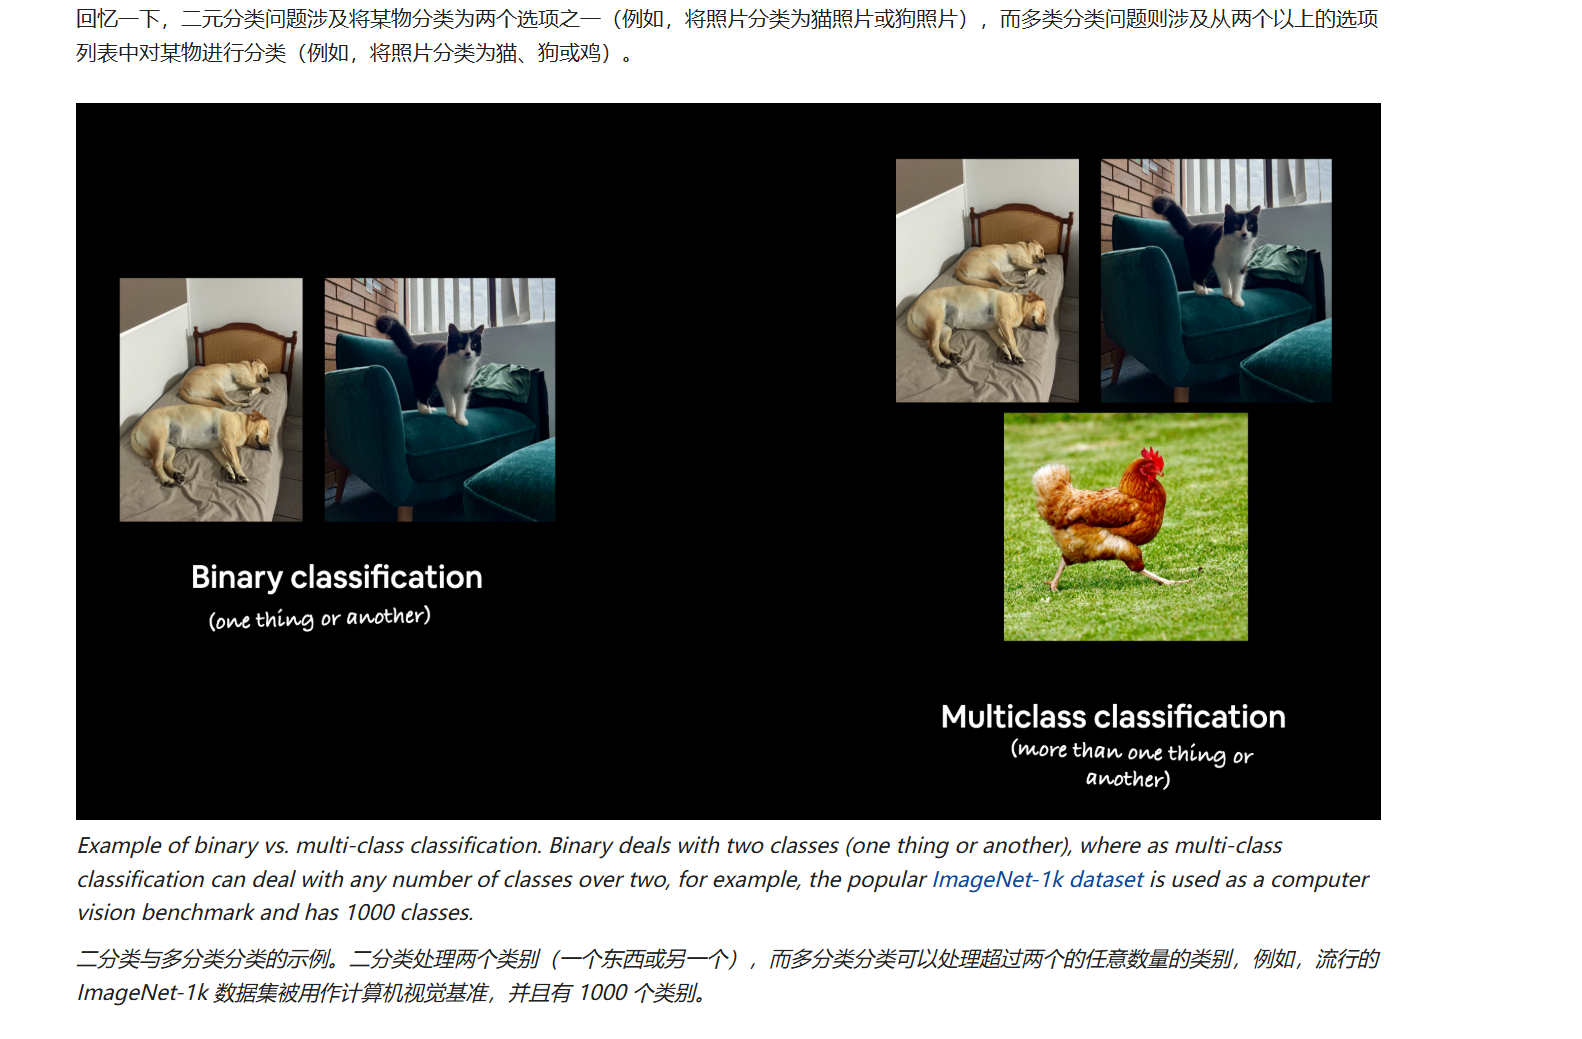

### 8.1 创建多类分类数据
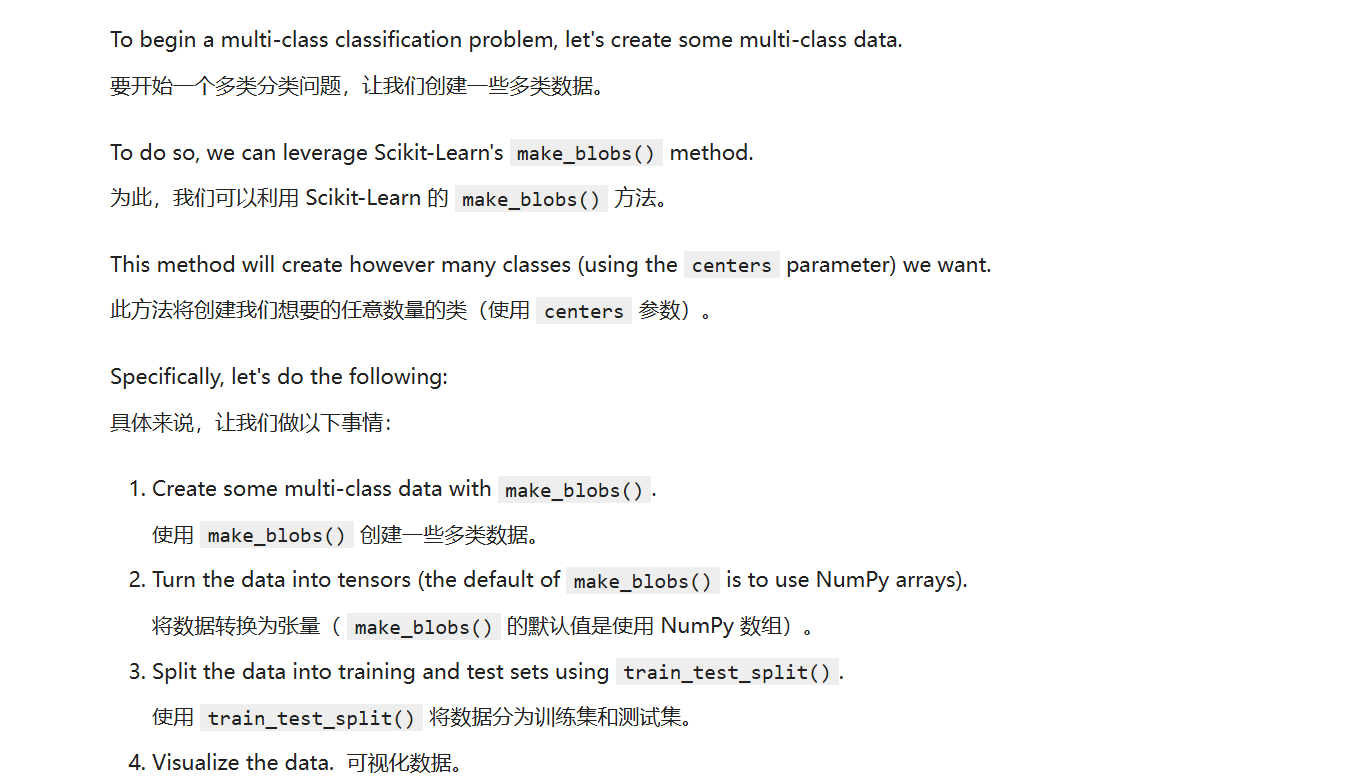

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


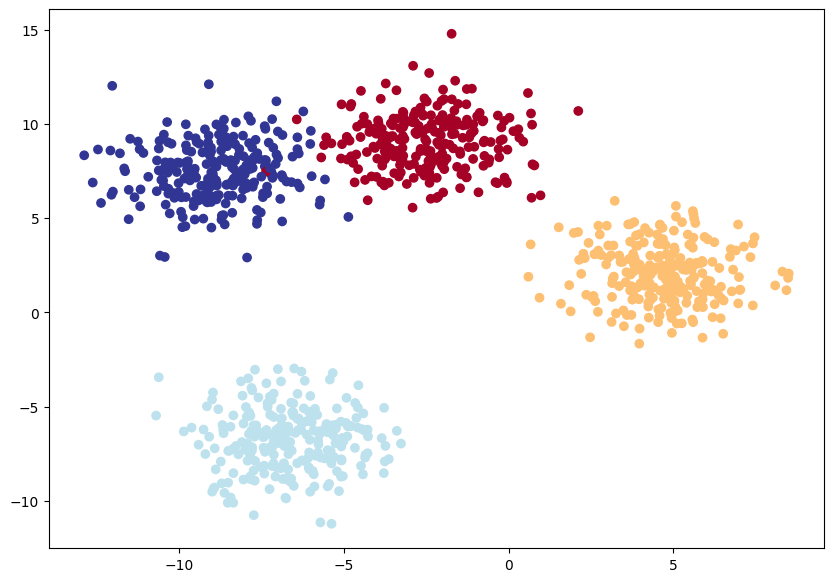

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

下面建立模型来分离彩色斑点

### 8.2 在Pytorch中构建多类分类模型
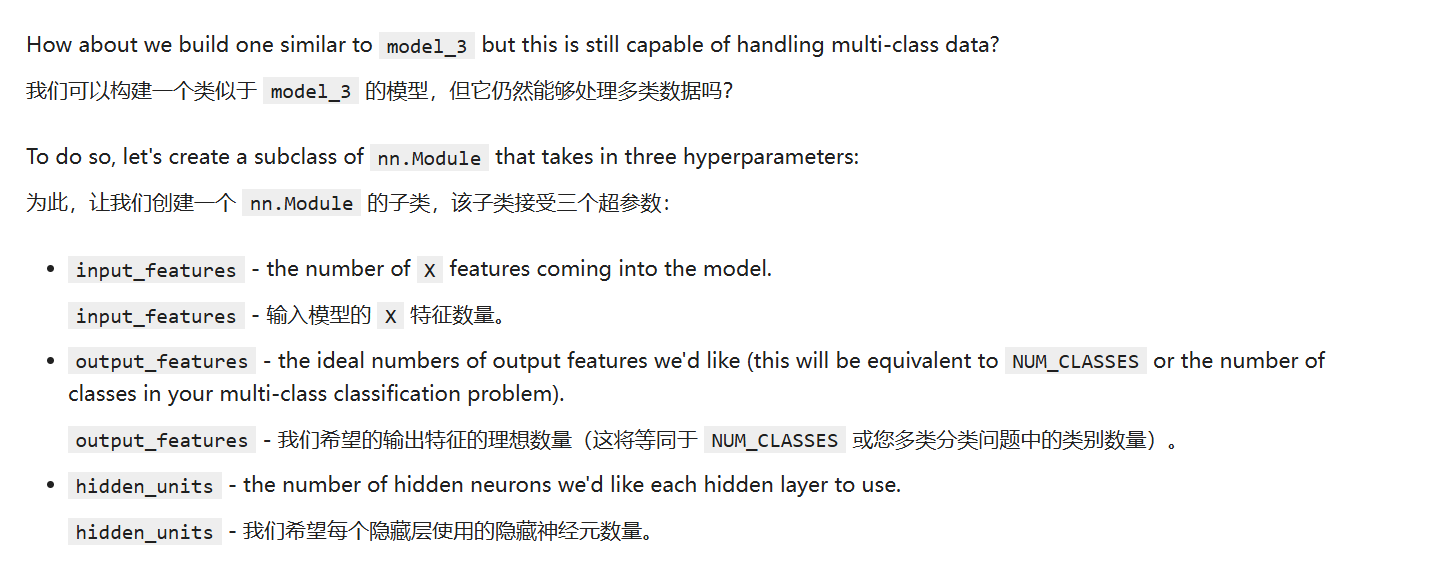

In [75]:
# 创建device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [82]:
from torch import nn

# 建立模型
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        初始化多类分类模型所需的所有超参数。

        参数：
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
                (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- 我们的数据集需要非线性层吗？尝试取消注释看看结果是否有变化
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- 我们的数据集需要非线性层吗？尝试取消注释看看结果是否有变化
            nn.Linear(in_features=hidden_units, out_features=output_features), # 这里有多少个类
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
# 创建实例，然后将他放到GPU上
model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=8
).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 为多类PyTorch模型创建损失函数和优化器
由于正在处理多类分类问题，所以将使用`nn.CrossEntropyLoss()`方法作为我们的损失函数。

继续使用学习率为`0.1`的`SGD`来优化`model_4`的参数。

In [83]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr = 0.1) # 尝试改变学习率，看结果

### 8.4 获取多类模型的预测概率

在此之前，将模型进行一次前向传播，查看是否有效。

In [85]:
# 在数据上执行一次正向传播（我们需要将其放置到目标设备上才能工作）
model_4(X_blob_train.to(device))[:5]

tensor([[-0.0502,  1.0892, -0.9358, -0.5434],
        [ 1.1727,  1.6699,  0.4098,  1.1535],
        [ 0.5955, -2.5124,  1.3582,  0.2746],
        [ 0.6280, -1.3875,  0.9445,  0.3419],
        [ 1.0989,  1.1515,  0.5245,  1.0415]], device='cuda:0',
       grad_fn=<SliceBackward0>)

进一步确认一下形状

In [86]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

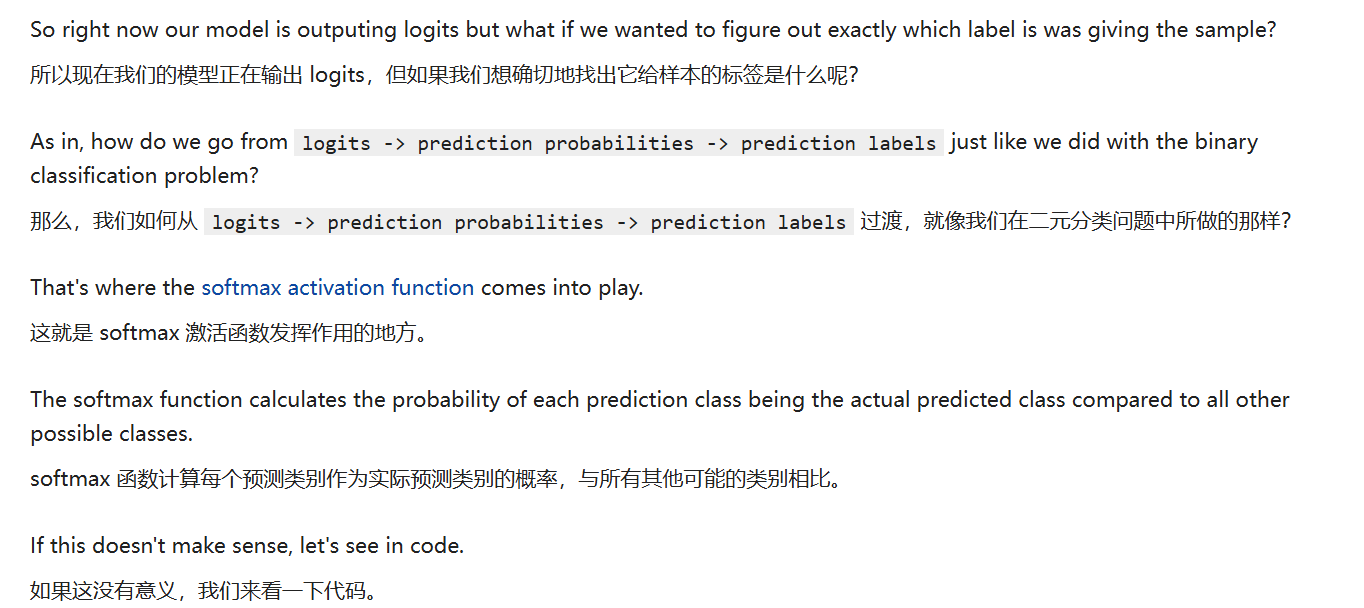

In [87]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0664,  1.2914, -0.8671, -0.3787],
        [ 1.5743,  0.6885,  1.3267,  1.6874],
        [ 0.4328, -2.0870,  0.9755,  0.0589],
        [-0.0438,  0.5513, -0.7096, -0.5453],
        [ 0.9490,  2.0080, -0.0165,  0.8519]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1839, 0.6260, 0.0723, 0.1178],
        [0.3019, 0.1245, 0.2356, 0.3380],
        [0.2866, 0.0231, 0.4931, 0.1972],
        [0.2543, 0.4611, 0.1307, 0.1540],
        [0.1934, 0.5576, 0.0736, 0.1755]], device='cuda:0',
       grad_fn=<SliceBackward0>)


在通过softmax函数处理之后，每个单独的样本现在总和为1（或者非常接近1）。

现在检查一下。

In [88]:
# 查看第一个样本
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

这些预测概率本质上是在说模型认为目标 X 样本（输入）映射到每个类别的程度。

由于在 y_pred_probs 中每个类别只有一个值，因此最高值的索引是模型认为特定数据样本最属于的类别。

我们可以使用 torch.argmax() 检查哪个索引具有最高值。

In [89]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1839, 0.6260, 0.0723, 0.1178], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


您可以看到 torch.argmax() 的输出为 1，因此对于索引 0 的样本的特征 ( X )，模型预测最可能的类别值 ( y ) 是 1。

当然，现在这只是随机猜测，所以它有 25%的正确概率（因为有四个类别）。但是我们可以通过训练模型来提高这些概率。

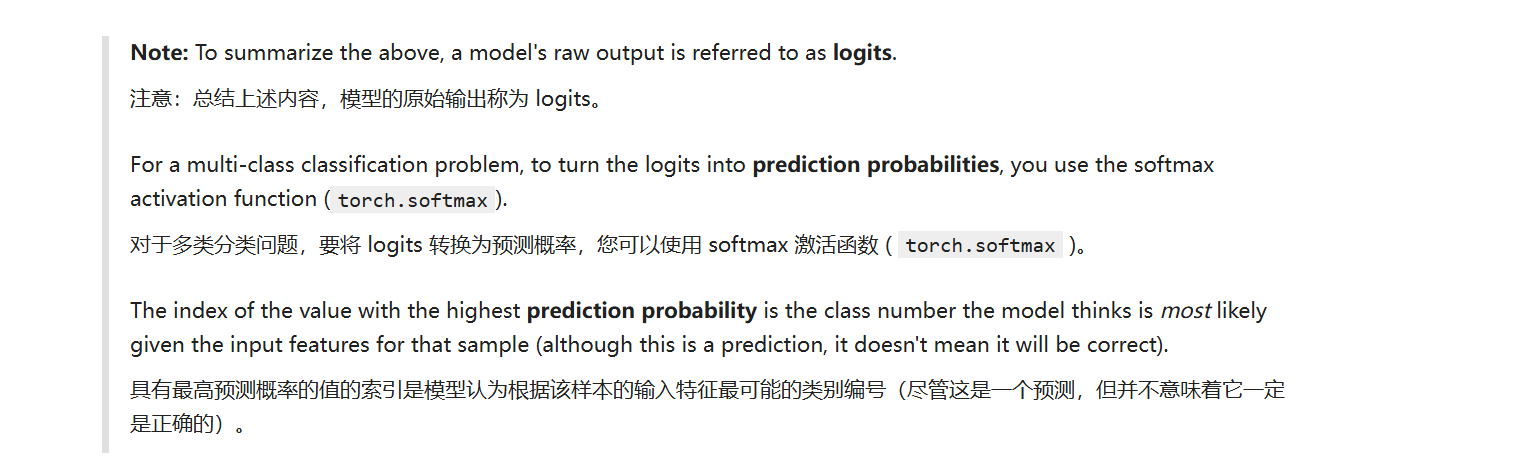

### 8.5 为多类 PyTorch 模型创建训练和测试循环

In [90]:
# 训练模型
torch.manual_seed(42)

# 设置epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. forward process
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.95460, Acc: 75.25% | Test Loss: 0.57363, Test Acc: 74.50%
Epoch: 10 | Loss: 0.14686, Acc: 99.12% | Test Loss: 0.12921, Test Acc: 100.00%
Epoch: 20 | Loss: 0.08170, Acc: 99.25% | Test Loss: 0.07284, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05978, Acc: 99.38% | Test Loss: 0.05168, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04910, Acc: 99.25% | Test Loss: 0.04104, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04290, Acc: 99.25% | Test Loss: 0.03473, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03889, Acc: 99.12% | Test Loss: 0.03056, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03611, Acc: 99.12% | Test Loss: 0.02762, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03408, Acc: 99.12% | Test Loss: 0.02543, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03254, Acc: 99.12% | Test Loss: 0.02374, Test Acc: 99.50%


看起来模型相当不错，做一些预测来可视化数据

In [91]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  6.6235,  12.3536, -11.9997,  -7.4498],
        [  4.4729, -11.5481,   2.6923,  10.0313],
        [ -9.3650, -15.5870,  16.6567,   8.3915],
        [  3.0281,   8.7299,  -6.9864,  -5.9141],
        [ 10.4825,   5.6883, -11.7020,  -1.0549],
        [  4.8141, -14.5401,   4.0112,  12.4276],
        [ -9.4359, -12.2927,  14.9447,   5.8570],
        [  8.6509,   1.0863,  -7.6653,   1.8277],
        [-10.0784, -21.2360,  20.3038,  12.4531],
        [  9.1583,   2.7363,  -8.9854,   0.7432]], device='cuda:0')

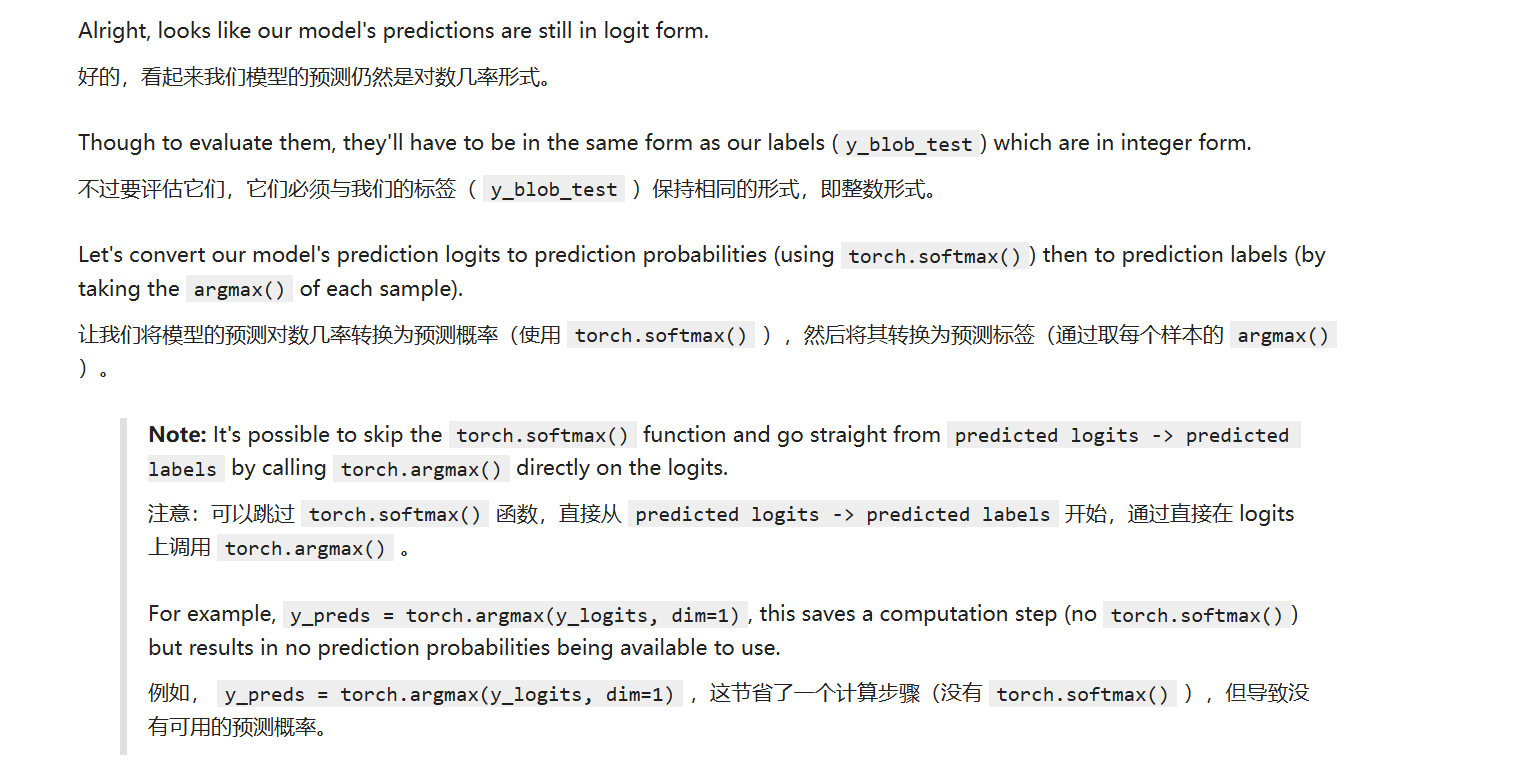

In [92]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


很好！我们的模型预测现在与我们的测试标签形式相同。

来可视化吧！记住目前数据在GPU上，所有必须将其转移到CPU上以便于matplotlib一起使用`plot_decision_boundary()`

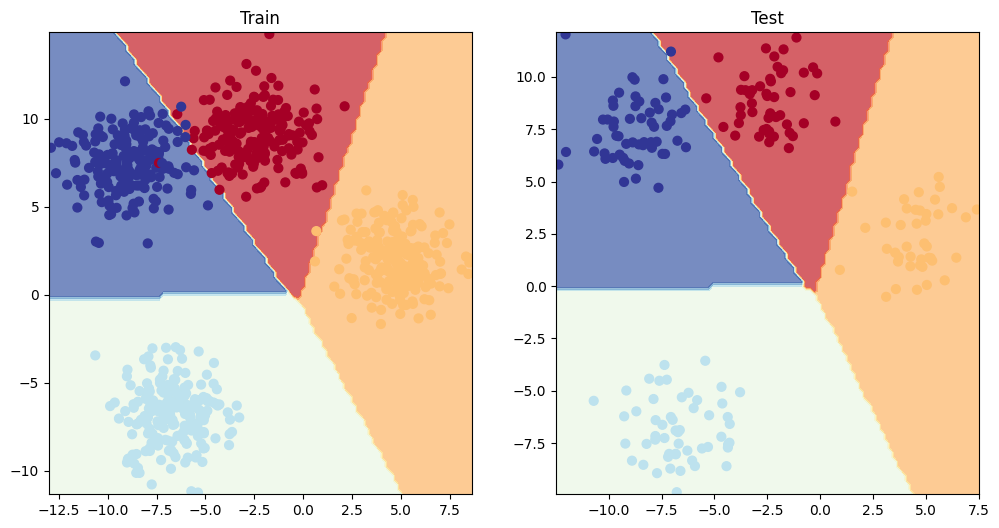

In [93]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. 更多分类评估指标

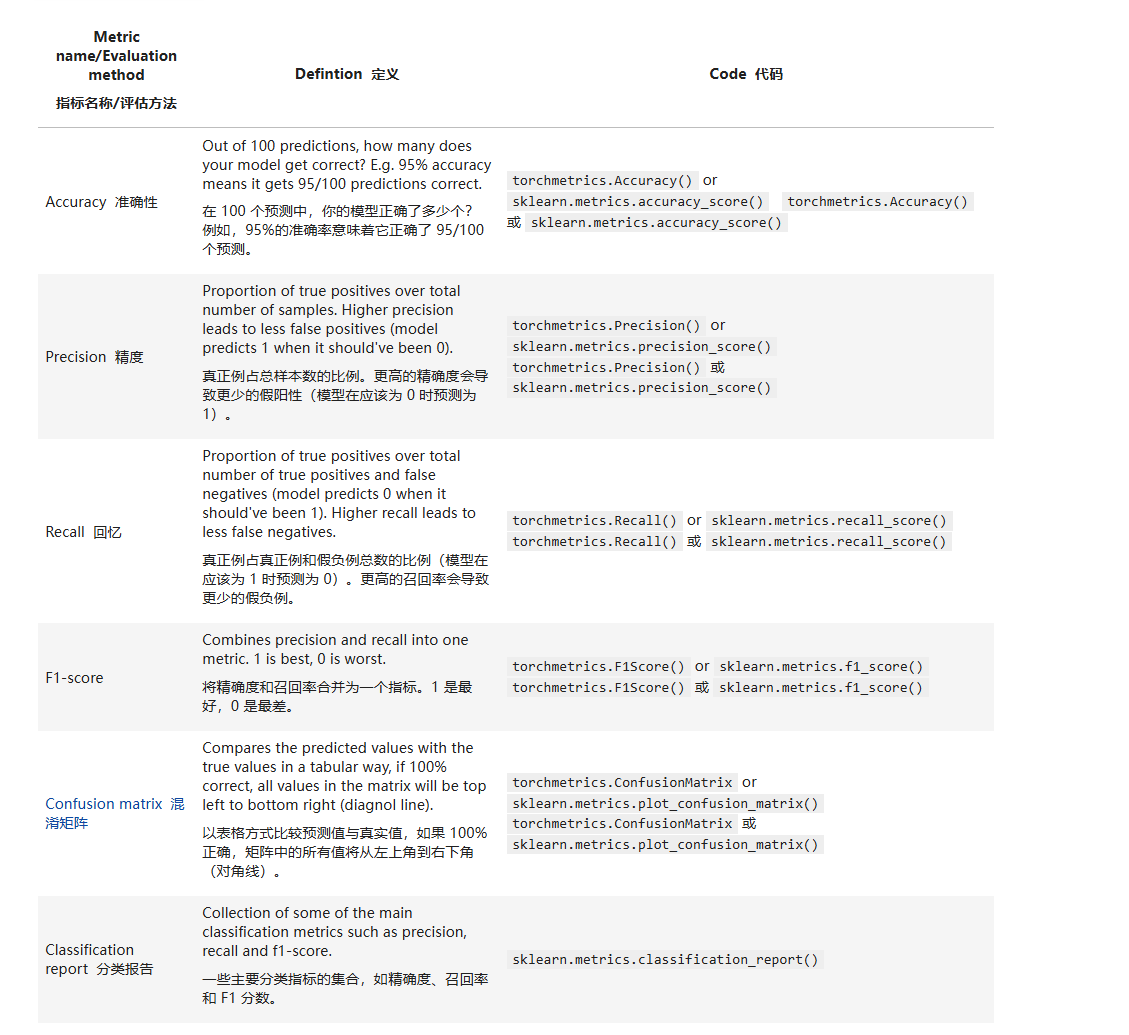

来试一下`torchmetrics.Accuracy`指标

In [95]:
try:
    from torchmetrics import Accuracy
except:
    %pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/enerated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')